In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import cmocean as cmo
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
%matplotlib inline

In [3]:
ds070 = xr.open_dataset('./data/ANMN/BMP070/aggregated/IMOS_ANMN-NSW_VZ_20150430_BMP070_FV01_velocity-aggregated-timeseries_END-20210119_C-20210222.nc')
ds120 = xr.open_dataset('./data/ANMN/BMP120/aggregated/IMOS_ANMN-NSW_VZ_20141118_BMP120_FV01_velocity-aggregated-timeseries_END-20210119_C-20210222.nc')

In [4]:
ds120

<xarray.Dataset>
Dimensions:                (OBSERVATION: 16149636, INSTRUMENT: 17)
Coordinates:
    DEPTH                  (OBSERVATION) float32 ...
    TIME                   (OBSERVATION) datetime64[ns] ...
    LATITUDE               (INSTRUMENT) float64 ...
    LONGITUDE              (INSTRUMENT) float64 ...
    NOMINAL_DEPTH          (INSTRUMENT) float32 ...
Dimensions without coordinates: OBSERVATION, INSTRUMENT
Data variables:
    UCUR                   (OBSERVATION) float32 ...
    VCUR                   (OBSERVATION) float32 ...
    WCUR                   (OBSERVATION) float32 ...
    UCUR_quality_control   (OBSERVATION) float32 ...
    VCUR_quality_control   (OBSERVATION) float32 ...
    WCUR_quality_control   (OBSERVATION) float32 ...
    DEPTH_quality_control  (OBSERVATION) float32 ...
    instrument_index       (OBSERVATION) int16 ...
    source_file            (INSTRUMENT) |S256 ...
    instrument_id          (INSTRUMENT) |S256 ...
    SECONDS_TO_MIDDLE      (INSTRUMENT) float32 ...
    CELL_INDEX             (OBSERVATION) int16 ...
Attributes: (12/39)
    contributor_name:              Roughan, Moninya; Austin, Timothy
    project:                       Integrated Marine Observing System (IMOS)
    rejected_files:                
    contributor_role:              principal_investigator; author
    date_created:                  2021-02-22T03:57:14Z
    file_version_quality_control:  Quality controlled data have been through ...
    ...                            ...
    geospatial_lat_max:            -36.2012166667
    acknowledgement:               Any users of IMOS data are required to cle...
    naming_authority:              IMOS
    keywords:                      UCUR, VCUR, WCUR, DEPTH, AGGREGATED
    history:                       2021-02-22T03:57:14Z: Aggregated file crea...
    author_email:                  eduardo.kleinsalas@utas.edu.au

In [5]:
# Select data
df070 = pd.DataFrame({'TIME': ds070.TIME, 'VCUR': ds070.VCUR, 'VCURqc': ds070.VCUR_quality_control,'DEPTH' : ds070.DEPTH, 'DEPTHqc' : ds070.DEPTH_quality_control}).set_index('TIME')
df120 = pd.DataFrame({'TIME': ds120.TIME, 'VCUR': ds120.VCUR, 'VCURqc': ds120.VCUR_quality_control,'DEPTH' : ds120.DEPTH, 'DEPTHqc' : ds120.DEPTH_quality_control}).set_index('TIME')
df070.head(5)

,VCUR,VCURqc,DEPTH,DEPTHqc
TIME,,,,
2015-04-30 04:55:00.000001024,-0.100,1.0,65.342247,1.0
2015-04-30 04:55:00.000001024,-0.180,1.0,61.342243,1.0
2015-04-30 04:55:00.000001024,-0.242,1.0,57.342243,1.0
2015-04-30 04:55:00.000001024,-0.268,1.0,53.342247,1.0
2015-04-30 04:55:00.000001024,-0.322,1.0,49.342247,1.0


In [6]:
# Quality control
df070 = df070[(df070.VCURqc == 1)&(df070.DEPTHqc == 1)]
df120 = df120[(df120.VCURqc == 1)&(df120.DEPTHqc == 1)]

In [7]:
# bin the data into depth bins (set inside the square brackets, using big bins for the moment to keep things simple), the 'labels' field gives the bins a name
binned070 = pd.cut(x=df070.DEPTH, bins=[10, 25, 60, np.inf], right=False, labels=['surface', '30-60' , 'bottom'])
grouped070 = df070.groupby(binned070)
ds070_surface = grouped070.get_group('surface').VCUR.resample('1D').mean()
ds070_middle = grouped070.get_group('30-60').VCUR.resample('1D').mean()
ds070_bottom = grouped070.get_group('bottom').VCUR.resample('1D').mean()

binned120 = pd.cut(x=df120.DEPTH, bins=[10, 25, 60, np.inf], right=False, labels=['surface', '30-60' , 'bottom'])
grouped120 = df120.groupby(binned120)
ds120_surface = grouped120.get_group('surface').VCUR.resample('1D').mean()
ds120_middle = grouped120.get_group('30-60').VCUR.resample('1D').mean()
ds120_bottom = grouped120.get_group('bottom').VCUR.resample('1D').mean()


# Convert back to xarray
ds070_surface = ds070_surface.to_xarray()
ds070_surface = ds070_surface.to_dataset()
ds070_middle = ds070_middle.to_xarray()
ds070_middle = ds070_middle.to_dataset()
ds070_bottom = ds070_bottom.to_xarray()
ds070_bottom = ds070_bottom.to_dataset()

ds120_surface = ds120_surface.to_xarray()
ds120_surface = ds120_surface.to_dataset()
ds120_middle = ds120_middle.to_xarray()
ds120_middle = ds120_middle.to_dataset()
ds120_bottom = ds120_bottom.to_xarray()
ds120_bottom = ds120_bottom.to_dataset()

In [8]:
# Load survey times
survey_time = pd.read_csv("/Users/lachlanphillips/Development/PhD/repos/Eudyptula/data/transects/survey_times.csv")
survey_time['start_UTC'] = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in survey_time['start_UTC']]
survey_time['end_UTC'] = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in survey_time['end_UTC']]

In [9]:
survey_time

,id,year,start_UTC,end_UTC
0,2015_S1,2015,2015-09-30 20:35:42,2015-10-07 22:29:08
1,2016_S1,2016,2016-09-15 22:00:37,2016-09-28 03:22:35
2,2016_S2,2016,2016-10-22 03:09:45,2016-11-02 02:27:31
3,2017_S1,2017,2017-08-14 22:34:51,2017-08-26 04:17:06
4,2017_S2,2017,2017-10-02 22:24:52,2017-10-13 05:04:28
5,2018_S1,2018,2018-08-22 22:38:58,2018-09-04 04:42:08
6,2018_S2,2018,2018-09-27 21:54:38,2018-10-01 02:33:09
7,2019_S1,2019,2019-09-24 01:26:33,2019-09-26 02:22:16
8,2019_S2,2019,2019-09-30 21:36:31,2019-10-02 05:57:46


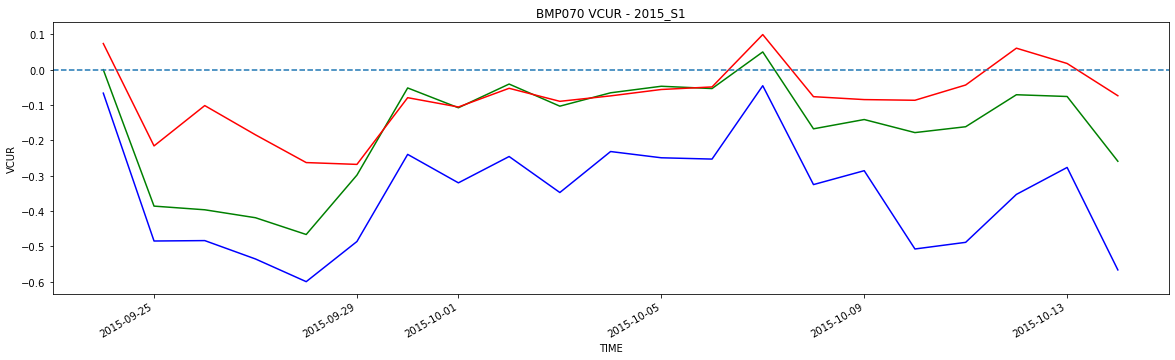

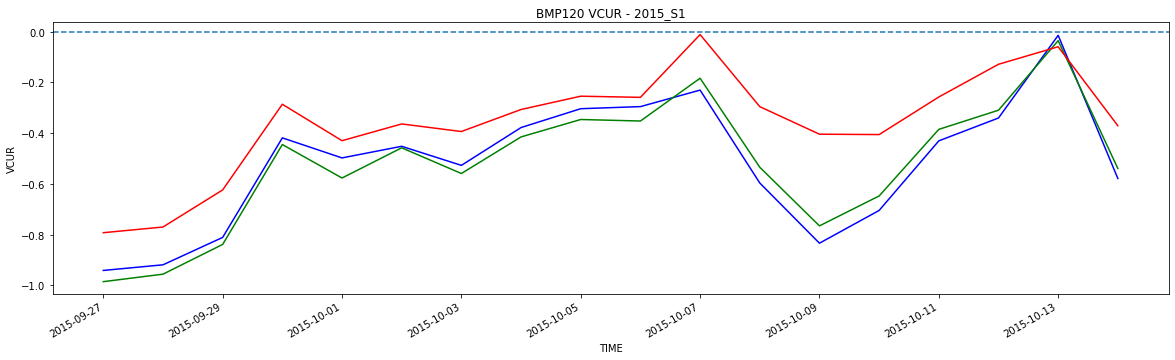

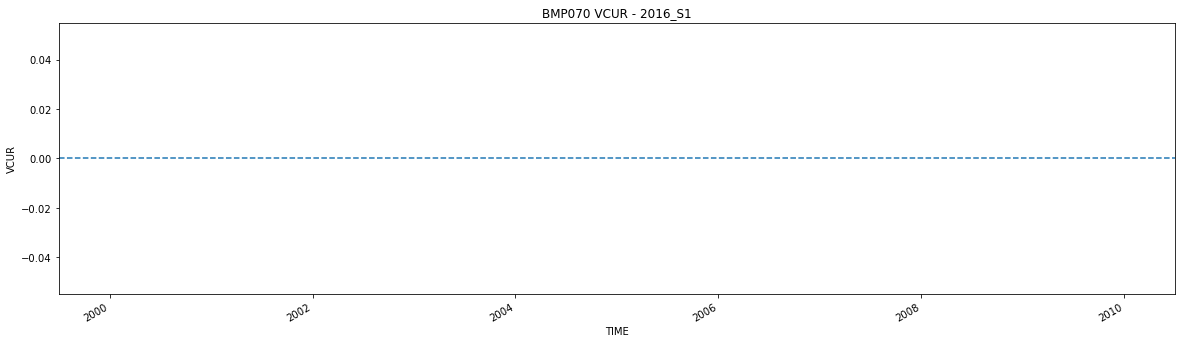

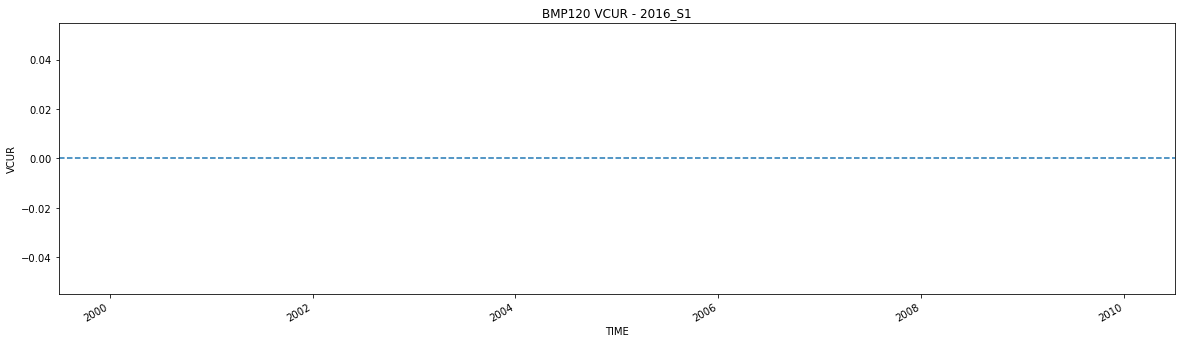

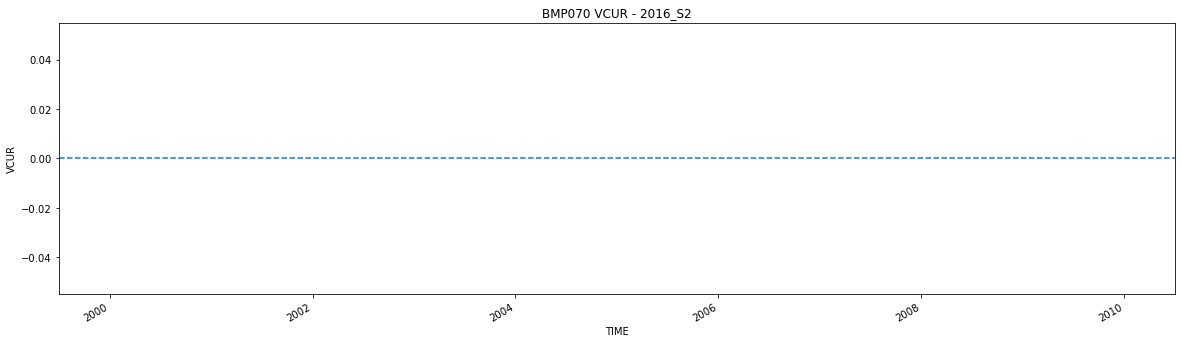

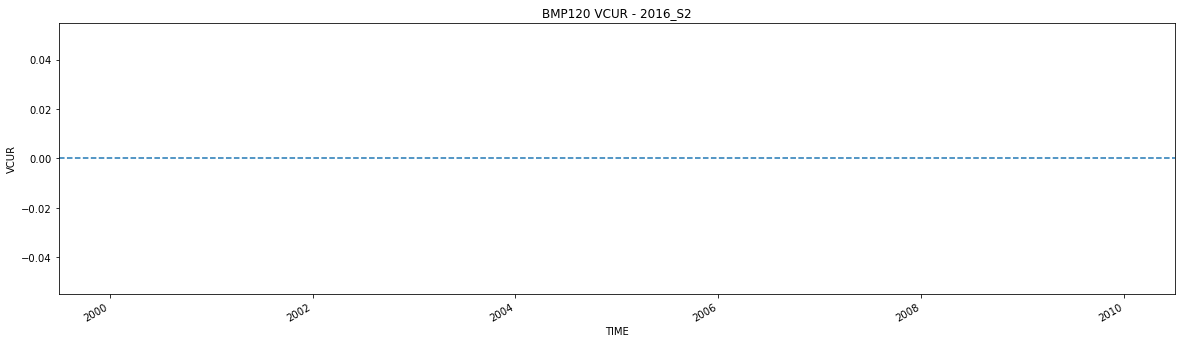

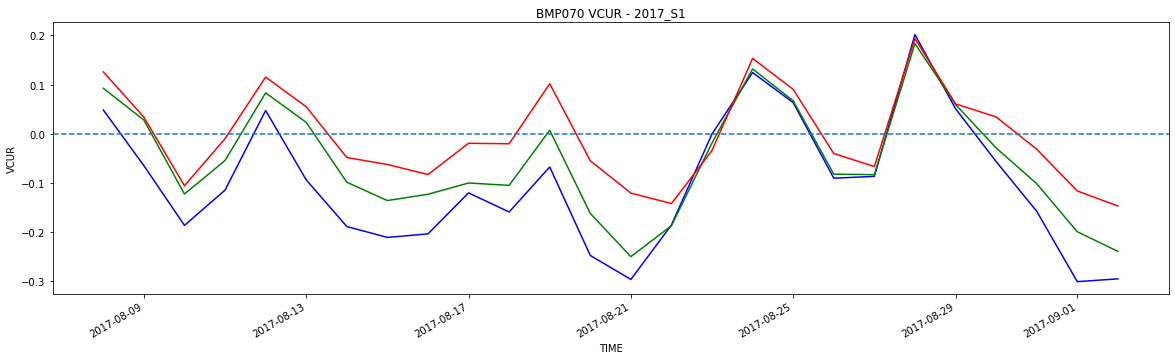

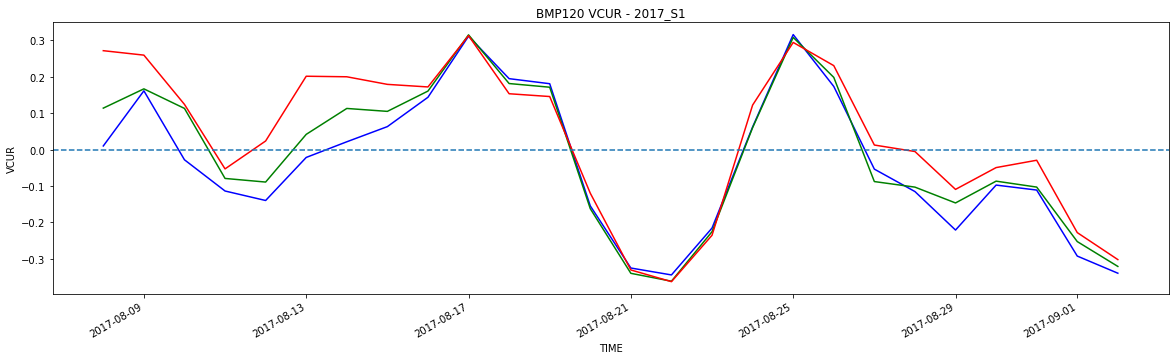

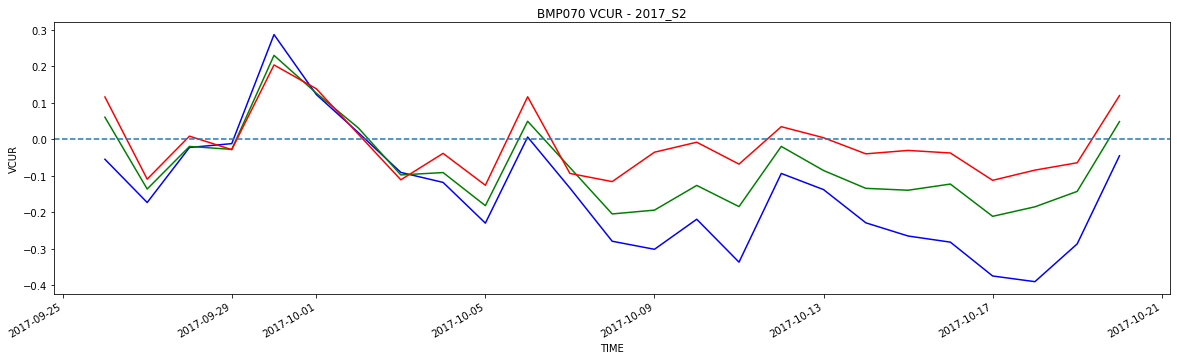

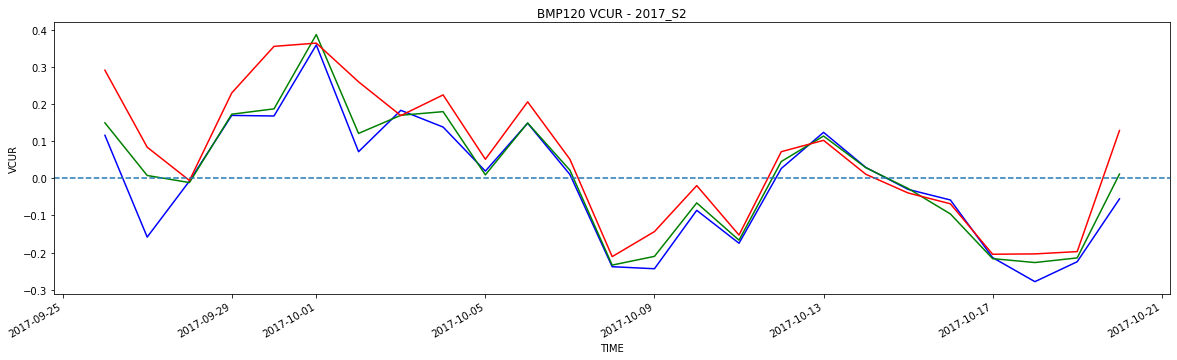

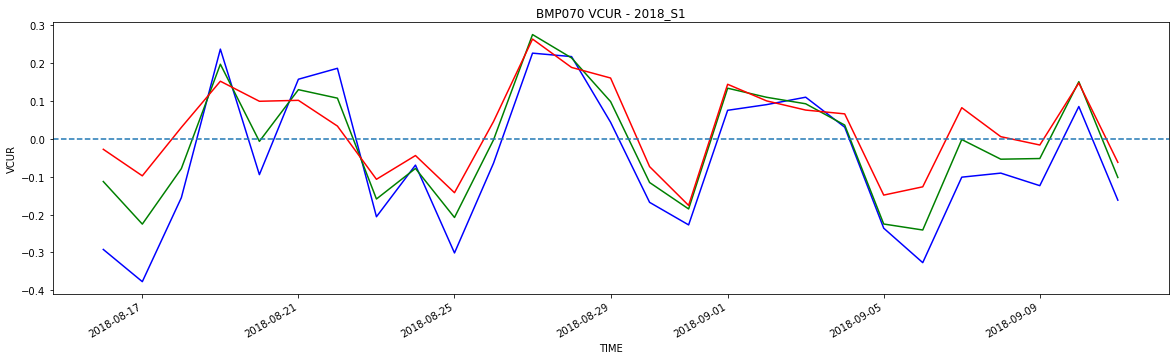

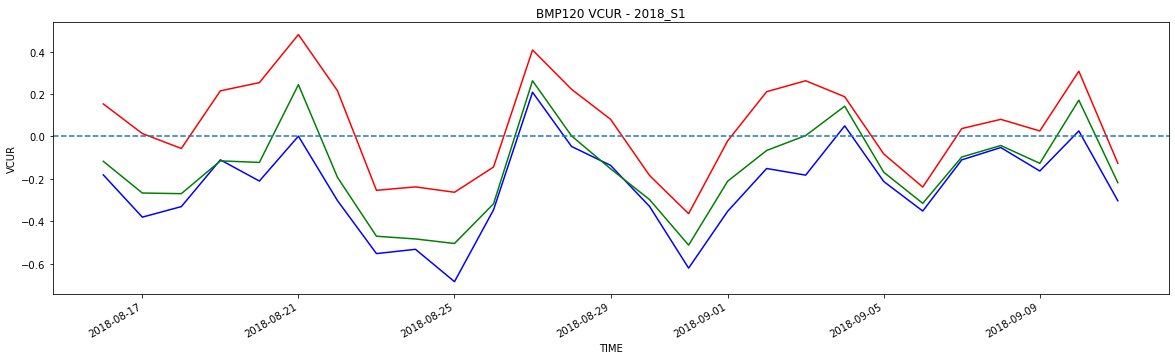

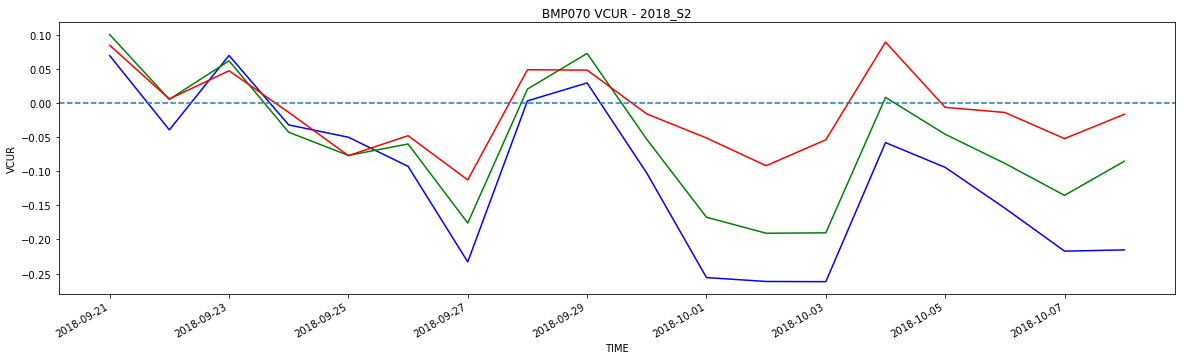

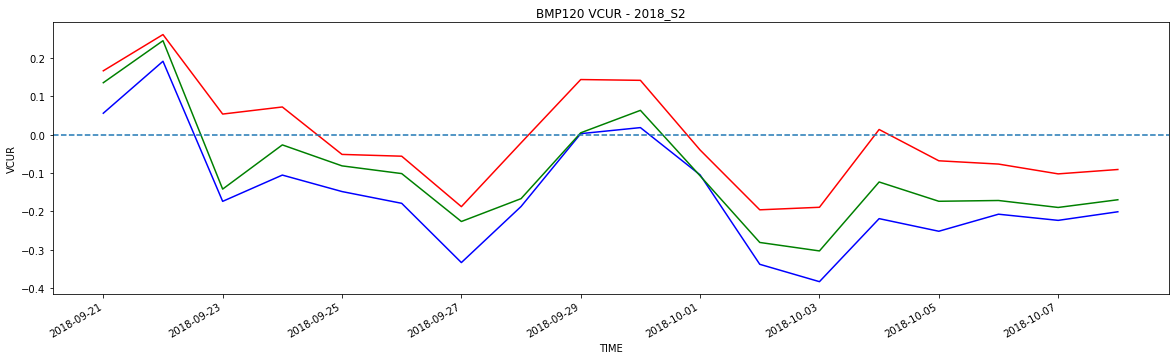

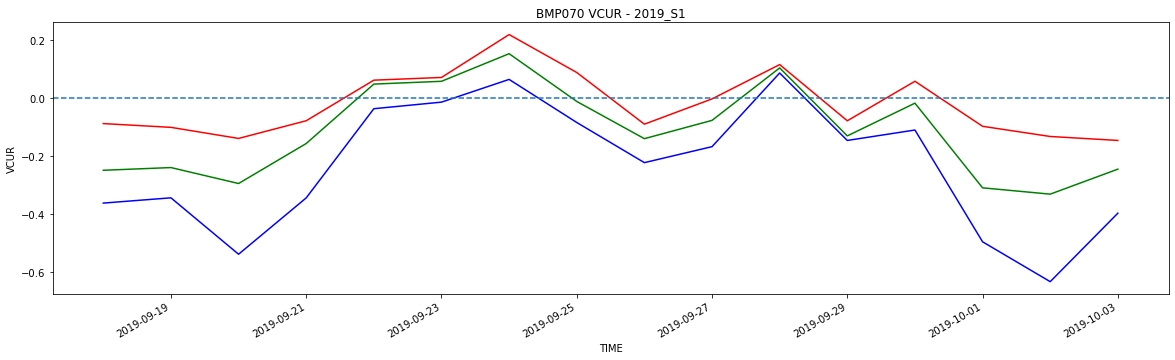

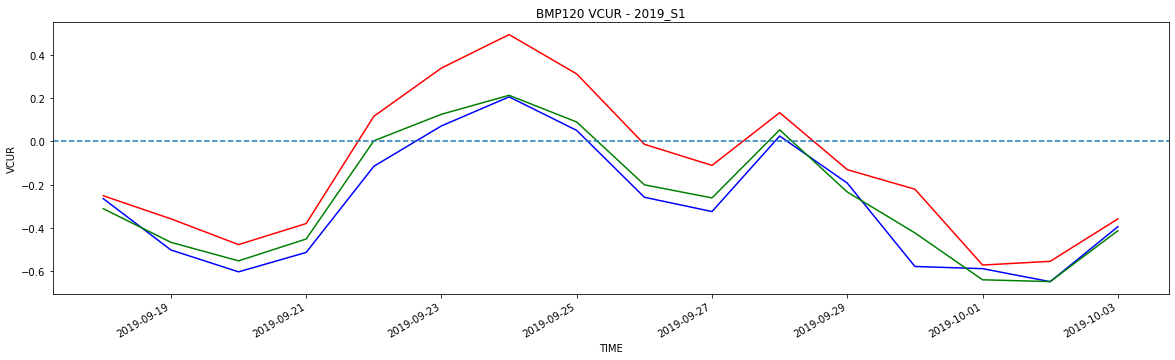

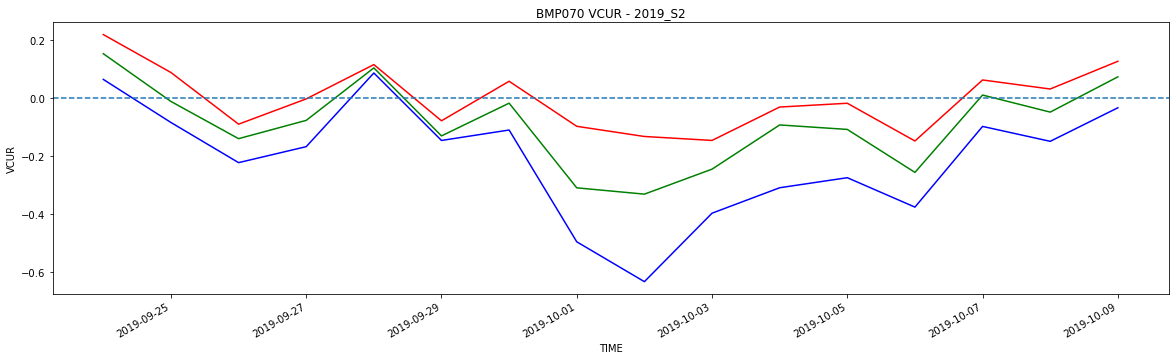

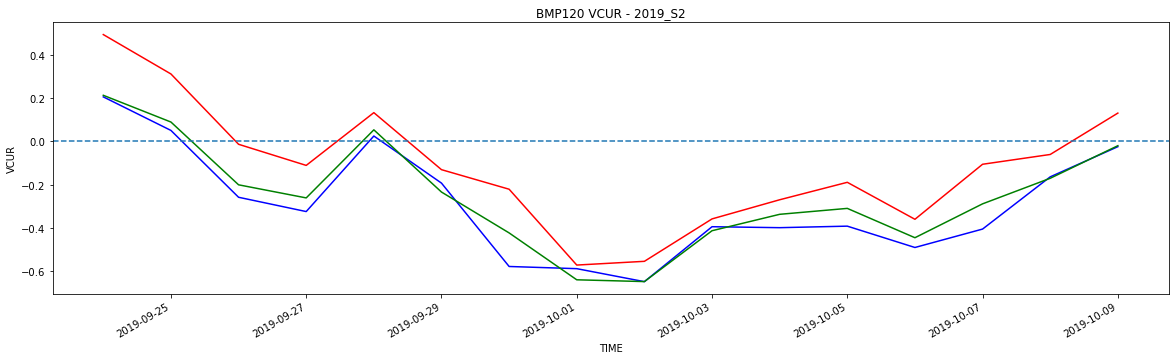

In [10]:
for i, row in survey_time.iterrows():
    dat070_surface = ds070_surface.sel(TIME=slice(row.start_UTC - timedelta(days=7), row.end_UTC + timedelta(days=7)))
    dat120_surface = ds120_surface.sel(TIME=slice(row.start_UTC - timedelta(days=7), row.end_UTC + timedelta(days=7)))
    dat070_middle = ds070_middle.sel(TIME=slice(row.start_UTC - timedelta(days=7), row.end_UTC + timedelta(days=7)))
    dat120_middle = ds120_middle.sel(TIME=slice(row.start_UTC - timedelta(days=7), row.end_UTC + timedelta(days=7)))
    dat070_bottom = ds070_bottom.sel(TIME=slice(row.start_UTC - timedelta(days=7), row.end_UTC + timedelta(days=7)))
    dat120_bottom = ds120_bottom.sel(TIME=slice(row.start_UTC - timedelta(days=7), row.end_UTC + timedelta(days=7)))
    
    if len(dat070_surface.TIME) > 0:
        # plot BMP070 velocity
        plt.figure(figsize=(20,5))
        dat070_surface.VCUR.plot(x='TIME', color='blue')
        dat070_middle.VCUR.plot(x='TIME', color='green')
        dat070_bottom.VCUR.plot(x='TIME', color='red')
        plt.axhline(y=0, linestyle='--')
        plt.title('BMP070 VCUR - '+row.id)
        plt.savefig('./output/anomalies/VCUR/'+row.id+'_BMP070_VCUR.png')
    
    if len(dat120_surface.TIME) > 0:
        # plot BMP120 anomaly
        plt.figure(figsize=(20,5))
        dat120_surface.VCUR.plot(x='TIME', color='blue')
        dat120_middle.VCUR.plot(x='TIME', color='green')
        dat120_bottom.VCUR.plot(x='TIME', color='red')
        plt.axhline(y=0, linestyle='--')
        plt.title('BMP120 VCUR - '+row.id)
        plt.savefig('./output/anomalies/VCUR/'+row.id+'_BMP120_VCUR.png')
                 